In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import scipy.io as sio
import netCDF4 as nc
import glob, os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
matplotlib.rcParams['animation.embed_limit'] =10000000000000000000000000.0
import cmocean
import xarray as xr
from xgcm import Grid

In [3]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [4]:
%cd /work/eay/MITgcm_data/Experiment32/
file1 = nc.Dataset('Salt.nc')
Time1 = file1.variables['T'][:]
xq = (file1.variables['X'][:])
yq = (file1.variables['Y'][:])

file4 = nc.Dataset('W.nc')
mask = file1.variables['S'][30,0,:,:]
W = (file4.variables['W'][65,1,:,:])
W[(mask==0)]=np.nan
print(Time1[65]/86400)

%cd /work/eay/MITgcm_data/Experiment32_diagshort/
state = nc.Dataset('state.nc')
surfDiag = xr.open_dataset('srfDiag.nc')
momDiag = nc.Dataset('momDiag.nc')
NX = 600
NY = 1000
NZ = 120

X = state.variables['X'][:]
Xp1 = state.variables['Xp1'][:]
Y = state.variables['Y'][:]
Yp1 = state.variables['Yp1'][:]

zl = state.variables['Z'][:]
Time = state.variables['T'][:]

%cd /work/eay/MITgcm_data/

/work2/eay/MITgcm_data/Experiment32
1.3541666666666667
/work2/eay/MITgcm_data/Experiment32_diagshort
/work2/eay/MITgcm_data



TOTUTEND/86400=Um_Diss+Um_Advec+Um_Cori+Um_dPhiX+Um_Ext+UDIAG1+Um_Impl
    Um_Ext is all zero
    Um_Impl is all zero in our case (I tested this and confirmed)

TOTVTEND/86400=Vm_Diss+Vm_Advec+Vm_Cori+Vm_dPhiX+Vm_Ext+UDIAG1+Um_Impl
    Vm_Ext is nonzero
    Vm_Impl is all zero in our case(I tested this and confirmed)


In [5]:
# #First compute the SSH gradient, not part of the momDiag file

# grid= Grid(surfDiag, coords={'X': {'center': 'X', 'outer': 'Xp1'}, #This tells the grid where xh, xq, yh, and yq are defined.
#                         'Y': {'center': 'Y', 'outer': 'Yp1'}});

# SSH = grid.interp(surfDiag.ETAN,axis='X')
# SSH_gradient = grid.interp(surfDiag.ETAN,axis='X').differentiate('Xp1')
# SSH_gradient = -SSH_gradient[0,0,:,:].values*9.81


In [6]:
z_index  = 0
print(Time[2]/86400)
TOTUTEND = momDiag['TOTUTEND'][2,z_index ,:,:]/86400
Um_Advec = momDiag['Um_Advec'][2,z_index ,:,:]
Um_Diss  = momDiag['Um_Diss'][2,z_index ,:,:]
Um_Cori  = momDiag['Um_Cori'][2,z_index ,:,:]
Um_dPhiX = momDiag['Um_dPhiX'][2,z_index ,:,:]
Um_Ext   = momDiag['Um_Ext'][2,z_index ,:,:]

ErrorU = TOTUTEND-Um_Advec-Um_Diss-Um_dPhiX-Um_Ext
print(TOTUTEND.shape,Um_Diss.shape, ErrorU.shape)


1.3541666666666667
(1000, 601) (1000, 601) (1000, 601)


## First plotting u and v components at the surface (so we do have the surface forcing term in y)

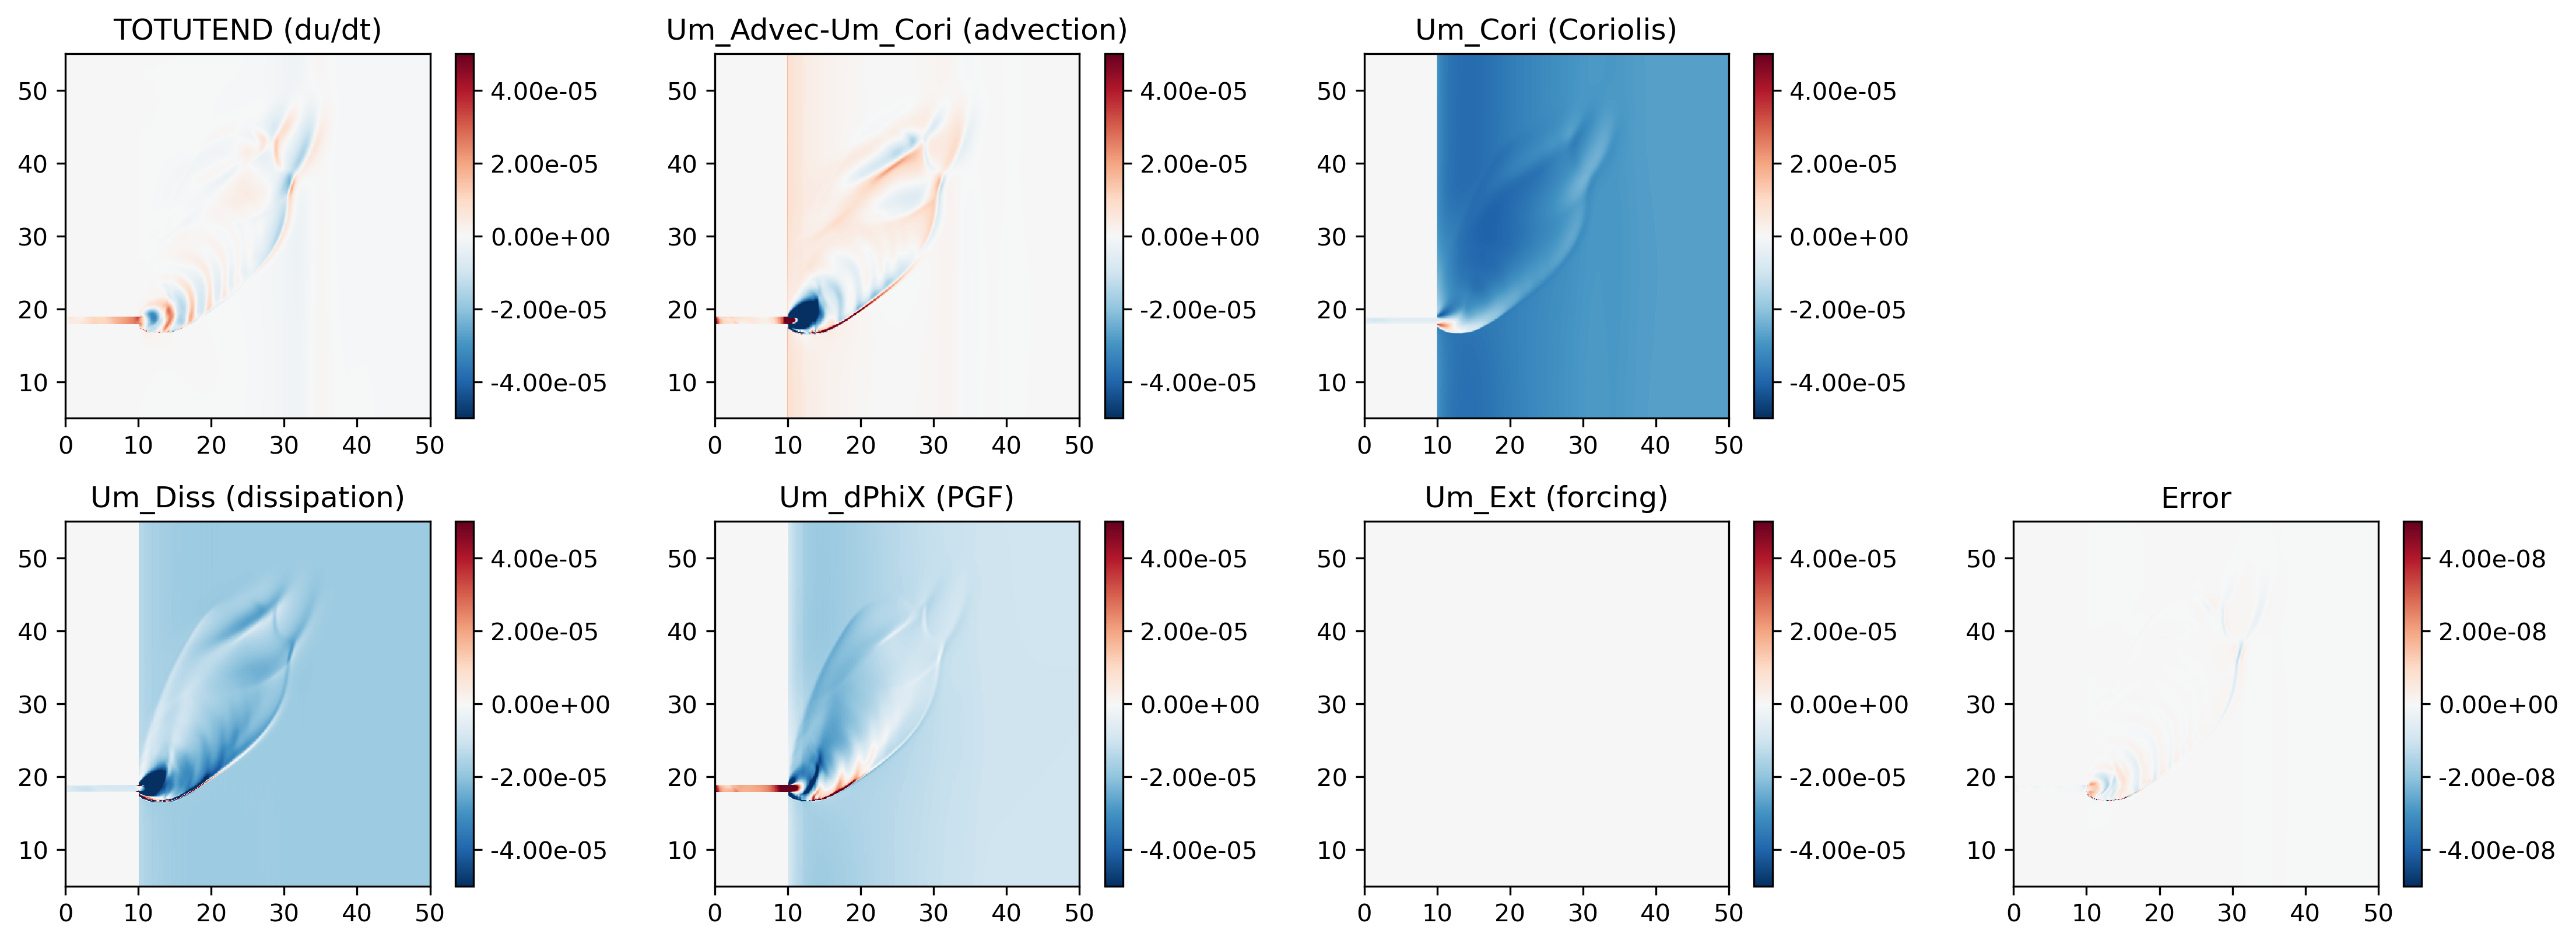

In [7]:
plt.figure(figsize=(15,5.5),dpi=300)


cmin=-.5e-4; cmax=.5e-4;
plt.subplot(2,4,1)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,TOTUTEND,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('TOTUTEND (du/dt)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,2)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,-(Um_Advec-Um_Cori),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Um_Advec-Um_Cori (advection)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,3)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,-Um_Cori,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Um_Cori (Coriolis)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,5)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_Diss,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Um_Diss (dissipation)')
plt.colorbar(format='%.2e')



plt.subplot(2,4,6)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_dPhiX,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Um_dPhiX (PGF)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,7)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_Ext,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Um_Ext (forcing)')
plt.colorbar(format='%.2e')

#

plt.subplot(2,4,8)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,ErrorU,cmap='RdBu_r',vmin=cmin/1000,vmax=cmax/1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Error')
plt.colorbar(format='%.2e')


plt.tight_layout()

In [8]:
z_index  = 0
TOTVTEND = momDiag['TOTVTEND'][2,z_index ,:,:]/86400
Vm_Advec = momDiag['Vm_Advec'][2,z_index ,:,:]
Vm_Diss  = momDiag['Vm_Diss'][2,z_index ,:,:]
Vm_Cori  = momDiag['Vm_Cori'][2,z_index ,:,:]
Vm_dPhiY = momDiag['Vm_dPhiY'][2,z_index ,:,:]
Vm_Ext   = momDiag['Vm_Ext'][2,z_index ,:,:]

ErrorV = TOTVTEND-Vm_Advec-Vm_Diss-Vm_dPhiY-Vm_Ext
print(TOTVTEND.shape,Vm_Diss.shape, ErrorV.shape)

(1001, 600) (1001, 600) (1001, 600)


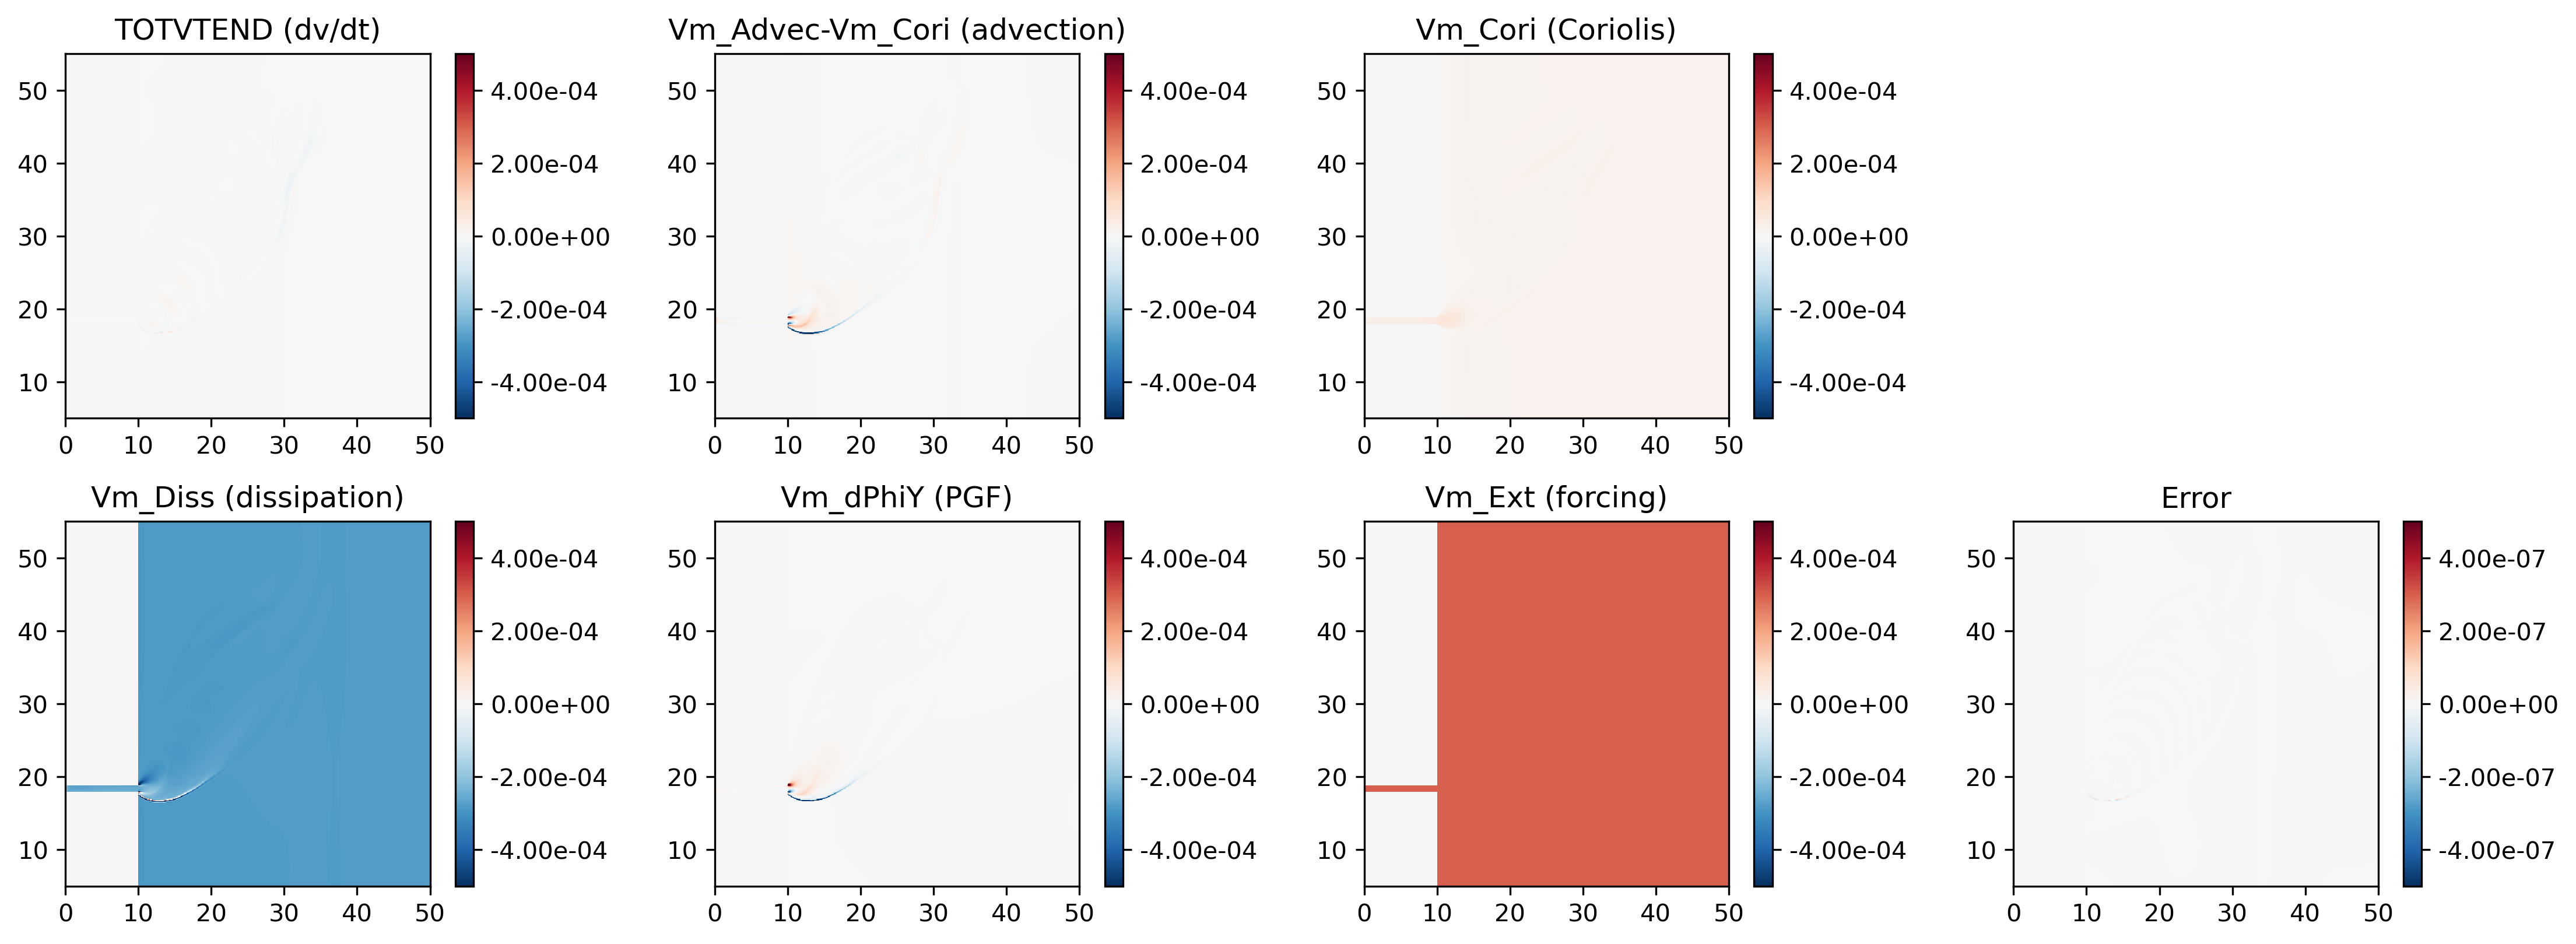

In [9]:
plt.figure(figsize=(15,5.5),dpi=300)

cmin=-.5e-3; cmax=.5e-3;
plt.subplot(2,4,1)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,TOTVTEND,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('TOTVTEND (dv/dt)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,2)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,-(Vm_Advec-Vm_Cori),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vm_Advec-Vm_Cori (advection)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,3)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,-Vm_Cori,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vm_Cori (Coriolis)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,5)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,Vm_Diss,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vm_Diss (dissipation)')
plt.colorbar(format='%.2e')



plt.subplot(2,4,6)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,Vm_dPhiY,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vm_dPhiY (PGF)')
plt.colorbar(format='%.2e')

plt.subplot(2,4,7)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,Vm_Ext,cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Vm_Ext (forcing)')
plt.colorbar(format='%.2e')

#

plt.subplot(2,4,8)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,ErrorV,cmap='RdBu_r',vmin=cmin/1000,vmax=cmax/1000)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Error')
plt.colorbar(format='%.2e')


plt.tight_layout()

In [10]:
## Now looking at 0.1 meter depth (no surface term)

In [11]:
z_index  = 1
TOTUTEND = momDiag['TOTUTEND'][2,z_index ,:,:]/86400; TOTUTEND[TOTUTEND==0]=np.nan
Um_Advec = momDiag['Um_Advec'][2,z_index ,:,:]; Um_Advec[Um_Advec==0]=np.nan
Um_Diss  = momDiag['Um_Diss'][2,z_index ,:,:];  Um_Diss[Um_Diss==0]=np.nan
Um_Cori  = momDiag['Um_Cori'][2,z_index ,:,:];  Um_Cori[Um_Cori==0]=np.nan
Um_dPhiX = momDiag['Um_dPhiX'][2,z_index ,:,:]; Um_dPhiX[Um_dPhiX==0]=np.nan
Um_Ext   = momDiag['Um_Ext'][2,z_index ,:,:]

ErrorU = TOTUTEND-Um_Advec-Um_Diss-Um_dPhiX-Um_Ext

TOTVTEND = momDiag['TOTVTEND'][2,z_index ,:,:]/86400; TOTVTEND[TOTVTEND==0]=np.nan
Vm_Advec = momDiag['Vm_Advec'][2,z_index ,:,:]; Vm_Advec[Vm_Advec==0]=np.nan
Vm_Diss  = momDiag['Vm_Diss'][2,z_index ,:,:];  Vm_Diss[Vm_Diss==0]=np.nan
Vm_Cori  = momDiag['Vm_Cori'][2,z_index ,:,:];  Vm_Cori[Vm_Cori==0]=np.nan
Vm_dPhiY = momDiag['Vm_dPhiY'][2,z_index ,:,:]; Vm_dPhiY[Vm_dPhiY==0]=np.nan
Vm_Ext   = momDiag['Vm_Ext'][2,z_index ,:,:]

ErrorV = TOTVTEND-Vm_Advec-Vm_Diss-Vm_dPhiY-Vm_Ext

print(TOTVTEND.shape,Vm_Diss.shape, ErrorV.shape)
print(TOTUTEND.shape,Um_Diss.shape, ErrorU.shape)



(1001, 600) (1001, 600) (1001, 600)
(1000, 601) (1000, 601) (1000, 601)


In [12]:
np.nanmin(W)

-0.0004865328

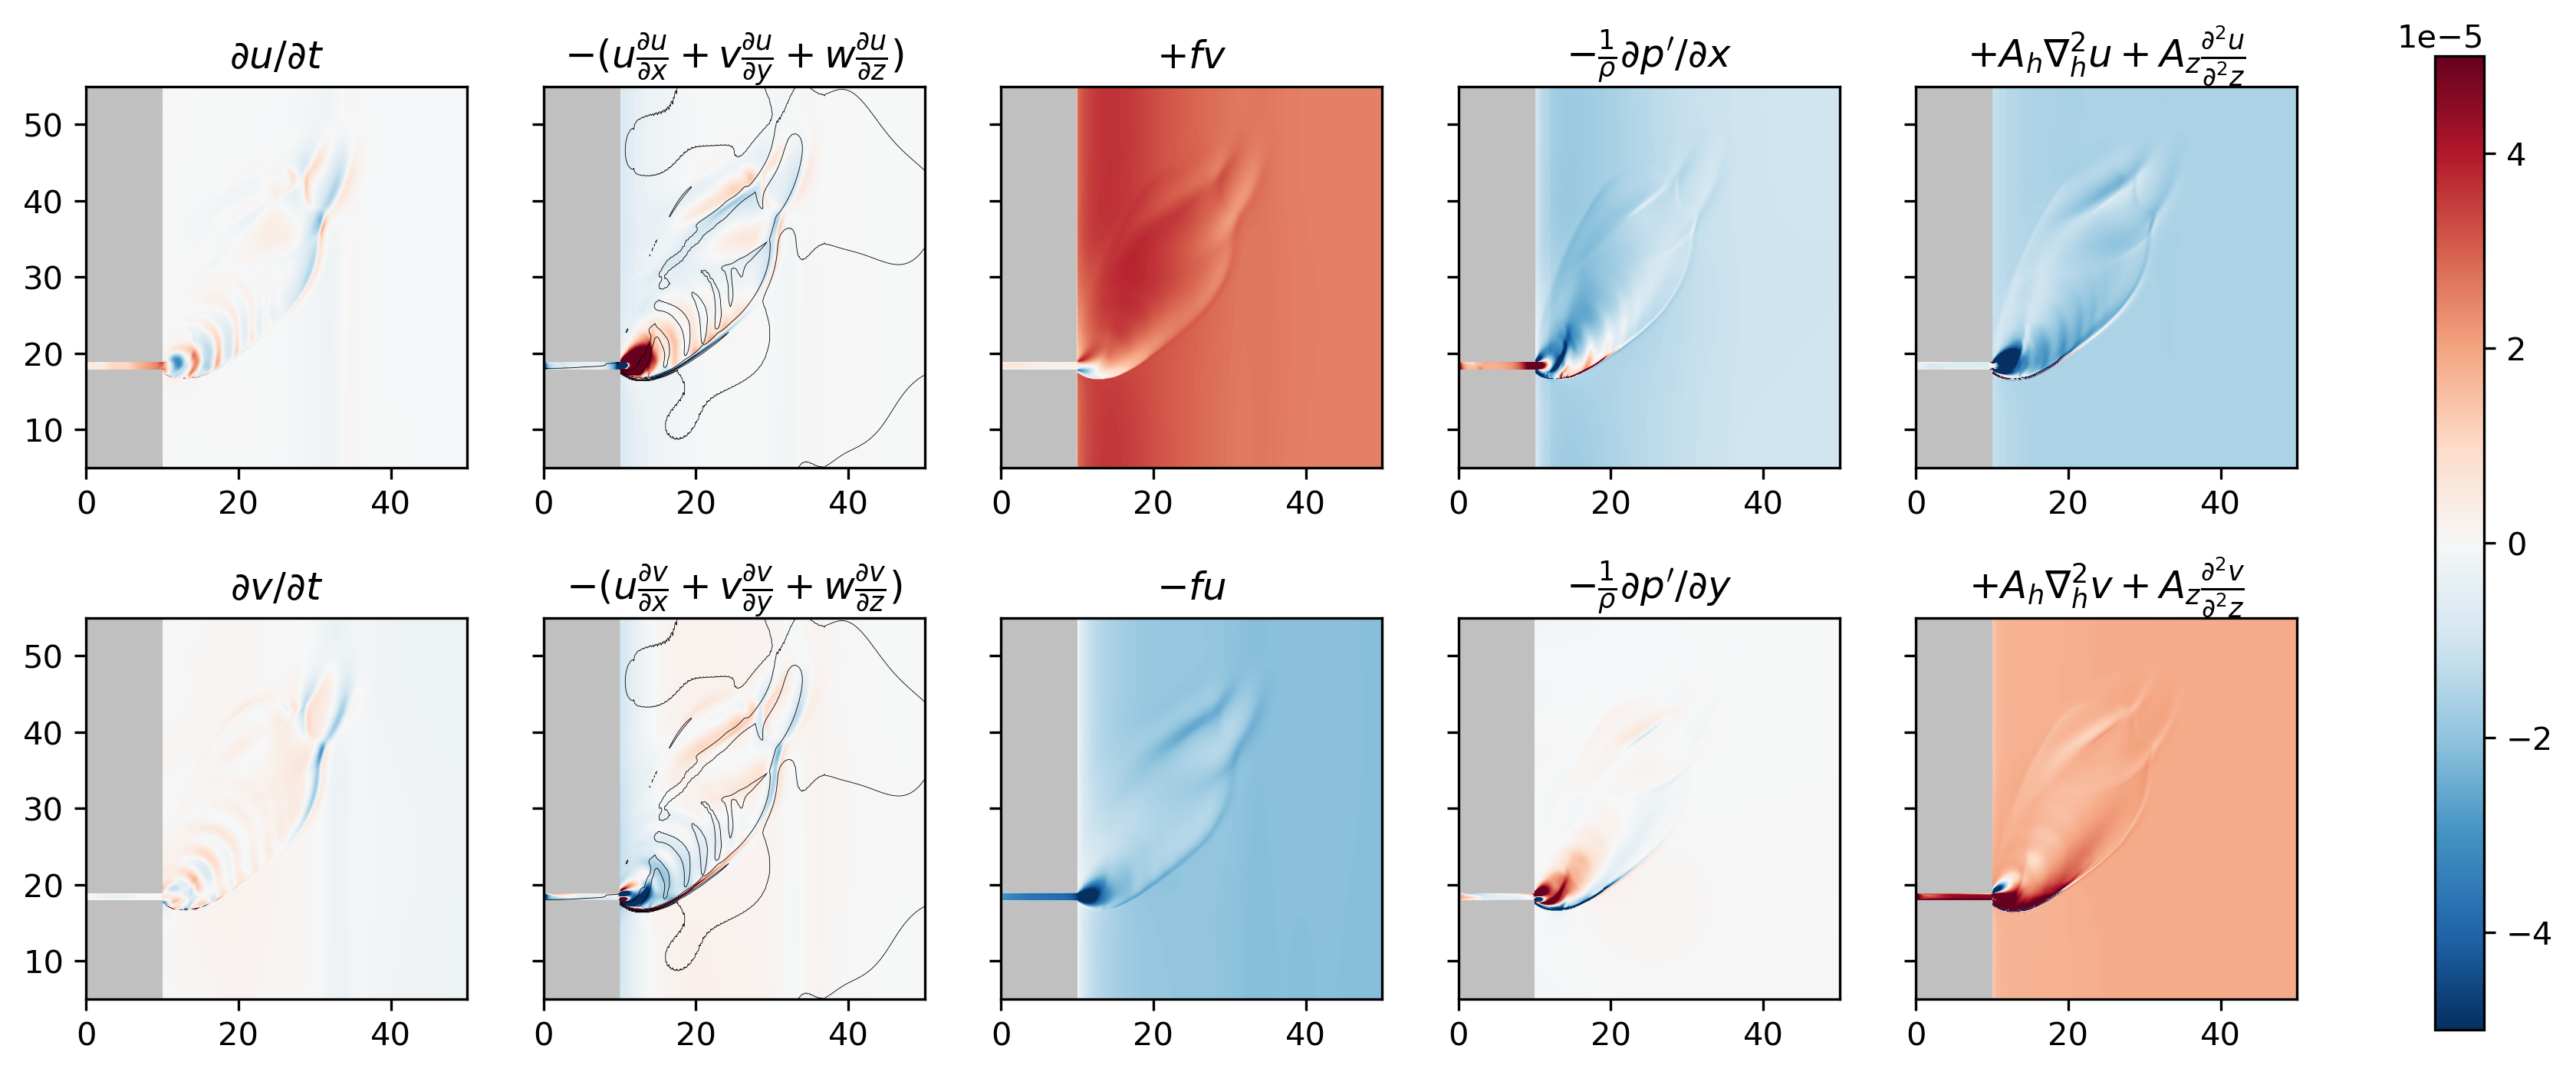

In [39]:
#fig=plt.figure(figsize=(12,5.5),dpi=300)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15.5,5.5),dpi=300)

current_cmap = plt.cm.get_cmap("RdBu_r").copy()
current_cmap.set_bad(color='silver')
cmin=-.5e-4; cmax=.5e-4;

## U Components:
ax=plt.subplot(2,5,1)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,TOTUTEND,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial u/ \partial t$')

ax=plt.subplot(2,5,2)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,(Um_Advec-Um_Cori),cmap=current_cmap,vmin=cmin,vmax=cmax)
ax.contour(xq/1000,yq/1000,W,levels=[-1e-7],colors='k',linewidths=.2,linestyles = 'solid')

plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-(u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + w \frac{\partial u}{\partial z})$')
ax.axes.set_yticklabels([])

ax=plt.subplot(2,5,3)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_Cori,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$+fv$')
ax.axes.set_yticklabels([])

ax=plt.subplot(2,5,4)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_dPhiX,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\frac{1}{\rho} \partial p^\prime/ \partial x$')
ax.axes.set_yticklabels([])

ax=plt.subplot(2,5,5)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(Xp1/1000,Y/1000,Um_Diss,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$+A_h \nabla^2_h u +A_z \frac{\partial^2 u}{\partial^2 z}$')
ax.axes.set_yticklabels([])

## V Components:
ax=plt.subplot(2,5,6)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,TOTVTEND,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial v/ \partial t$')

ax=plt.subplot(2,5,7)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,(Vm_Advec-Vm_Cori),cmap=current_cmap,vmin=cmin,vmax=cmax)
ax.contour(xq/1000,yq/1000,W,levels=[-1e-7],colors='k',linewidths=.2,linestyles = 'solid')

plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-(u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + w \frac{\partial v}{\partial z})$')
ax.axes.set_yticklabels([])

ax=plt.subplot(2,5,8)
plt.xlim([0,50]);plt.ylim([5,55])
plt.pcolormesh(X/1000,Yp1/1000,Vm_Cori,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-fu$')
ax.axes.set_yticklabels([])


ax=plt.subplot(2,5,9)
plt.xlim([0,50]);plt.ylim([5,55]); 
plt.pcolormesh(X/1000,Yp1/1000,Vm_dPhiY,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\frac{1}{\rho} \partial p^\prime / \partial y$')
ax.axes.set_yticklabels([])

ax=plt.subplot(2,5,10)
plt.xlim([0,50]);plt.ylim([5,55]); 
im=plt.pcolormesh(X/1000,Yp1/1000,Vm_Diss,cmap=current_cmap,vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$+A_h \nabla^2_h v +A_z \frac{\partial^2 v}{\partial^2 z}$')
#plt.colorbar(format='%.2e')
ax.axes.set_yticklabels([])



cbar = fig.colorbar(im, ax=axes.ravel().tolist())

In [1]:
#plt.pcolormesh(W-np.nanmean(W),vmin=-1e-6,vmax=1e-6,cmap='RdBu_r')